<a href="https://colab.research.google.com/github/Akechi1412/Vietnamese-Review-Classification/blob/master/train.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Tải thư viện pyvi và spacy để tách từ tiếng Việt.

In [ ]:
!pip install pyvi https://gitlab.com/trungtv/vi_spacy/-/raw/master/packages/vi_core_news_lg-3.6.0/dist/vi_core_news_lg-3.6.0.tar.gz

Clone github chứa các module cần thiết đã xây dựng dưới local.

In [2]:
!rm -rf Vietnamese-Review-Classification
!git clone https://github.com/Akechi1412/Vietnamese-Review-Classification
%cd Vietnamese-Review-Classification
!rm -f ./models/review_model.h5

Cloning into 'Vietnamese-Review-Classification'...
remote: Enumerating objects: 139, done.
remote: Counting objects: 100% (43/43), done.
remote: Compressing objects: 100% (15/15), done.
remote: Total 139 (delta 35), reused 29 (delta 28), pack-reused 96
Receiving objects: 100% (139/139), 30.24 MiB | 31.25 MiB/s, done.
Resolving deltas: 100% (71/71), done.
/content/Vietnamese-Review-Classification


Load dữ liệu đánh giá của người dùng đã thu thập được.

Preparing data...
Data size: 9000
Max number of words: 476
['đọc', 'cuốn', 'sách', 'tập', '1', 'mình', 'đã', 'nhận', 'ra', 'những', 'điều', 'thiếu sót', 'trong', 'quá trình', 'quản trị', 'doanh nghiệp', 'của', 'mình', 'chưa', 'có', 'tầm', 'nhìn', 'sứ mệnh', 'và', 'các', 'giá trị', 'cốt lõi', 'dẫn', 'đến', 'lúng túng', 'và', 'không thể', 'vận hành', 'doanh nghiệp', '1', 'cách', 'trơn tru', 'trong', 'sách', 'còn', 'có', 'nhiều', 'quà', 'tặng', 'đi', 'kèm', 'cực', 'giá trị', 'mình', 'đọc', 'mà', 'quên', 'cả', 'ăn', 'luôn', 'đúng', 'là', 'cuốn', 'sách', 'giá trị', 'trong', 'các', 'cuốn', 'sách', 'mình', 'đã', 'từng', 'đọc']
0


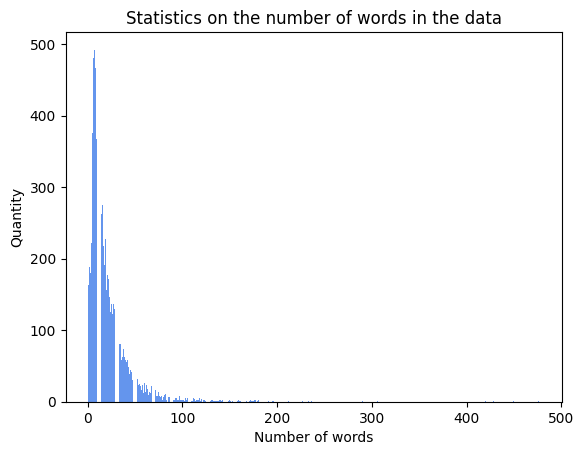

In [3]:
from utils.data_preparing import prepare_data
from utils.plotter import plot_reviews_data

x_data, y_data = prepare_data()

print(f'Data size: {len(x_data)}')
print(f'Max number of words: {len(max(x_data, key=len))}')
print(x_data[0])
print(y_data[0])

plot_reviews_data(x_data)

Nhận xét: Ta thấy số lượng từ của đánh giá người dùng phần lớp là từ 200 từ trở xuống, tập trung nhiều nhất là dưới 100 từ, vì vậy tiếp theo ta cần giới hạn số lượng từ cần xử lý tối đa là 200 từ để đảm bảo các danh sách từ của mỗi đánh giá là bằng nhau.

Tách dữ liệu đã thu thập được thành 3 phần: tập train, tập validation và tập test theo tỉ lệ 4:1:1.

In [4]:
from sklearn.model_selection import train_test_split

# Split data into train, validation, and test sets
x_train, x_temp, y_train, y_temp = train_test_split(x_data, y_data, test_size=1/3, random_state=42)
x_val, x_test, y_val, y_test = train_test_split(x_temp, y_temp, test_size=0.5, random_state=42)

print(len(x_train), len(y_train))
print(len(x_val), len(y_val))
print(len(x_test), len(y_test))

6000 6000
1500 1500
1500 1500


Chuyển đổi danh sách các từ thành các chuỗi số.

In [5]:
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.utils import to_categorical
import pickle

# Tokenize text data
tokenizer = Tokenizer()
tokenizer.fit_on_texts(x_train)

x_train_seq = tokenizer.texts_to_sequences(x_train)
x_val_seq = tokenizer.texts_to_sequences(x_val)
x_test_seq = tokenizer.texts_to_sequences(x_test)

# Save tokenize
with open('./models/review_tokenizer.pkl', 'wb') as file:
    pickle.dump(tokenizer, file)

# Pad sequences to ensure uniform length
max_len = 200
x_train_pad = pad_sequences(x_train_seq, maxlen=max_len)
x_val_pad = pad_sequences(x_val_seq, maxlen=max_len)
x_test_pad = pad_sequences(x_test_seq, maxlen=max_len)

print(f'({len(x_train_pad)}, {len(x_train_pad[0])})')
print(f'({len(x_val_pad)}, {len(x_val_pad[0])})')
print(f'({len(x_test_pad)}, {len(x_test_pad[0])})')

# Create one hot
y_train_one_hot = to_categorical(y_train, num_classes=3)
y_val_one_hot = to_categorical(y_val, num_classes=3)
y_test_one_hot = to_categorical(y_test, num_classes=3)

(6000, 200)
(1500, 200)
(1500, 200)


Chuyển dữ liệu sang dạng numpy array.

In [6]:
import numpy as np

x_train_pad = np.array(x_train_pad)
x_val_pad = np.array(x_val_pad)
x_test_pad = np.array(x_test_pad)

y_train_one_hot = np.array(y_train_one_hot)
y_val_one_hot = np.array(y_val_one_hot)
y_test_one_hot = np.array(y_test_one_hot)

Xây dựng và huấn luyện mô hình.

In [10]:
import tensorflow as tf
from keras.models import Sequential
from keras.layers import Embedding, LSTM, Dropout, Dense
from keras.layers import SpatialDropout1D, Conv1D, MaxPooling1D, Bidirectional
from keras.callbacks import ModelCheckpoint
from keras import regularizers
from keras.optimizers import Nadam
from keras.metrics import Precision, Recall

# Define individual RNN models
def build_rnn_model():
    model = Sequential()
    model.add(Embedding(input_dim=len(tokenizer.word_index)+1, output_dim=200, input_length=max_len))
    model.add(SpatialDropout1D(0.1))
    model.add(Conv1D(filters=64, kernel_size=3, padding='same', activation='relu'))
    model.add(MaxPooling1D(pool_size=2))
    model.add(Conv1D(filters=128, kernel_size=3, padding='same', activation='relu'))
    model.add(MaxPooling1D(pool_size=2))
    model.add(Bidirectional(LSTM(units=256, return_sequences=True)))
    model.add(Bidirectional(LSTM(units=128)))
    model.add(Dense(units=128, activation='relu', kernel_regularizer=regularizers.L2(0.000001)))
    model.add(Dropout(rate=0.20))
    model.add(Dense(units=64, activation='relu', kernel_regularizer=regularizers.L2(0.000001)))
    model.add(Dropout(rate=0.20))
    model.add(Dense(units=32, activation='relu', kernel_regularizer=regularizers.L2(0.000001)))
    model.add(Dropout(rate=0.20))
    model.add(Dense(units=16, activation='relu', kernel_regularizer=regularizers.L2(0.000001)))
    model.add(Dropout(rate=0.20))
    model.add(Dense(units=3, activation='softmax'))
    optimizer = Nadam(learning_rate=0.001)
    metrics = ['accuracy', Precision(), Recall()]
    model.compile(loss='categorical_crossentropy', optimizer=optimizer, metrics=metrics)
    return model

# Create ensemble of RNN models
ensemble_models = [build_rnn_model() for _ in range(10)]

# Lists to store minimum val_loss for each model
min_val_losses = []

# Train each individual model
for i, model in enumerate(ensemble_models):
    print(f"Training model {i+1}")
    # Define EarlyStopping callback to monitor val_loss
    early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss',
                                                  min_delta=0.001,
                                                  patience=3,
                                                  restore_best_weights=True)
    # Train the model with EarlyStopping callback
    history = model.fit(
      x_train_pad,
      y_train_one_hot,
      batch_size=40,
      epochs=10,
      validation_data=(x_val_pad, y_val_one_hot),
      callbacks=[early_stopping]
    )
    # Extract minimum val_loss from history and append to min_val_losses
    min_val_loss = min(history.history['val_loss'])
    min_val_losses.append(min_val_loss)
    print("Minimum val_loss for model", i+1, ":", min_val_loss)

# Print minimum val_loss across all models
print("Minimum val_loss across all models:", min(min_val_losses))

# Find model has min val_loss
best_model_index = min_val_losses.index(min(min_val_losses))

# Get the corresponding model from ensemble_models
best_model = ensemble_models[best_model_index]

# Save best model
best_model.save('./models/review_model.keras')
best_model.save('./models/review_model.h5')

Training model 1
Epoch 1/10
150/150 [==============================] - 48s 206ms/step - loss: 0.9426 - accuracy: 0.5420 - precision_10: 0.6264 - recall_10: 0.3057 - val_loss: 0.6101 - val_accuracy: 0.7793 - val_precision_10: 0.8120 - val_recall_10: 0.7460
Epoch 2/10
150/150 [==============================] - 16s 109ms/step - loss: 0.5838 - accuracy: 0.7900 - precision_10: 0.8467 - recall_10: 0.6950 - val_loss: 0.5200 - val_accuracy: 0.8100 - val_precision_10: 0.8743 - val_recall_10: 0.7327
Epoch 3/10
150/150 [==============================] - 9s 61ms/step - loss: 0.4356 - accuracy: 0.8378 - precision_10: 0.8929 - recall_10: 0.7933 - val_loss: 0.5354 - val_accuracy: 0.8147 - val_precision_10: 0.8615 - val_recall_10: 0.7673
Epoch 4/10
150/150 [==============================] - 8s 52ms/step - loss: 0.3265 - accuracy: 0.8663 - precision_10: 0.9195 - recall_10: 0.8225 - val_loss: 0.5438 - val_accuracy: 0.8013 - val_precision_10: 0.8691 - val_recall_10: 0.7527
Epoch 5/10
150/150 [===========

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


Vẽ lại đồ thị giá trị mất mát và độ chính xác cho tập train và tập validation của mô hình tốt nhất thu được từ quá trình huấn luyện.

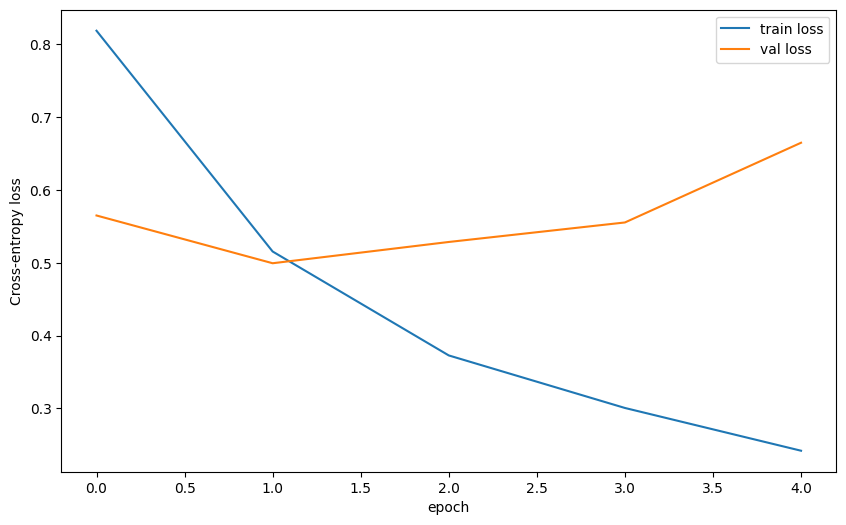

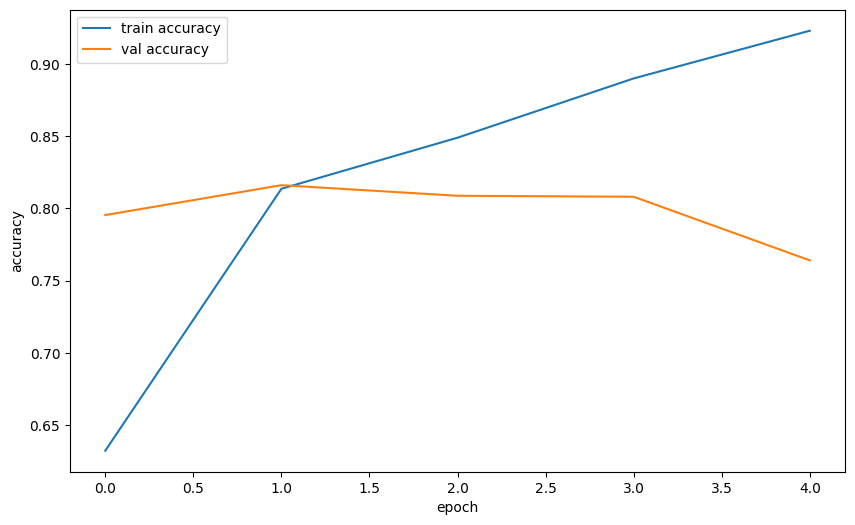

In [11]:
from utils.plotter import plot_history_model

plot_history_model(best_model.history)

Kiểm tra lại mô hình trên tập test.

In [14]:
from sklearn.metrics import confusion_matrix

scores = model.evaluate(x_test_pad, y_test_one_hot, batch_size=15, verbose=2)
print('Test scores:', scores)

y_pred = model.predict(x_test_pad, batch_size=15)
y_test_single = np.argmax(y_test_one_hot, axis=1)
y_pred_single = np.argmax(y_pred, axis=1)
conf_matrix = confusion_matrix(y_test_single, y_pred_single)
print("Confusion Matrix:")
print(conf_matrix)

100/100 - 1s - loss: 0.5025 - accuracy: 0.7993 - precision_19: 0.8411 - recall_19: 0.7693 - 771ms/epoch - 8ms/step
Test scores: [0.502494752407074, 0.7993333339691162, 0.8411078453063965, 0.7693333625793457]
100/100 [==============================] - 2s 7ms/step
Confusion Matrix:
[[741  60   0]
 [ 45 458   0]
 [ 77 119   0]]


Nhận xét: accuracy của tập test sau khi áp dụng mô hình đã huấn luyện là không quá tệ, tuy nhiên nhìn cột thứ 3 của confusion matrix ta thấy các đánh giá trung tính có độ chính xác không cao, rất dễ dự đoán sai sang tích cực hoặc tiêu cực và hoàn toàn không có dự đoán vào vào cảm xúc trung tính. Điều này xảy ra là do dữ liệu huấn luyện chưa đủ lớn, số lượng nhãn trung tính trong dữ liệu tương đối ít so với hai nhãn còn lại và sự khó khăn trong việc phân biệt giữa cảm xúc của một đánh giá phức tạp dẫn đến gắn nhãn sai.